<a href="https://colab.research.google.com/github/Minzana/finalDo_DrugDiscoveryHIV/blob/main/finalDo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
import pandas as pd
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define your file path (Change this to where your CSV is stored in your Drive)
# Example: '/content/drive/MyDrive/Research/hiv_protease_data.csv'
file_path = '/content/drive/MyDrive/Colab Notebooks/Final proj Drug Discovery Final/final dataset hopeful.csv'

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully!")
    print(df.head())
else:
    print("Check your file path! Data not found.")

Mounted at /content/drive
Dataset loaded successfully!
                    Name  Phase                   Drug Type  \
0             PENTOSALEN   -1.0  1:Synthetic Small Molecule   
1            PIRAGLIATIN   -1.0  1:Synthetic Small Molecule   
2            ATIPAMEZOLE    1.0  1:Synthetic Small Molecule   
3  DOXYCYCLINE ANHYDROUS    4.0  1:Synthetic Small Molecule   
4             VERDINEXOR    1.0  1:Synthetic Small Molecule   

   Passes Rule of Five            Chirality  \
0                    1     Achiral Molecule   
1                    1  Single Stereoisomer   
2                    1     Achiral Molecule   
3                    0  Single Stereoisomer   
4                    1     Achiral Molecule   

                                              Smiles  \
0                   CC(C)=CCOc1c2occc2cc2ccc(=O)oc12   
1  CS(=O)(=O)c1ccc([C@@H](C[C@H]2CCC(=O)C2)C(=O)N...   
2                        CCC1(c2c[nH]cn2)Cc2ccccc2C1   
3  C[C@H]1c2cccc(O)c2C(=O)C2=C(O)[C@]3(O)C(=O)C(C...   
4  

In [3]:
pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 27.4 MB/s eta 0:00:00


In [4]:
from rdkit import Chem
import pandas as pd
import numpy as np

def clean_smiles_data(df):
    # 1. Automatically find the SMILES column
    possible_names = [col for col in df.columns if 'smiles' in col.lower()]

    if not possible_names:
        print("Error: Could not find a SMILES column. Your columns are:", df.columns.tolist())
        return []

    target_col = possible_names[0]
    print(f"Using column: '{target_col}' for SMILES data.")
    print(f"Starting with {len(df)} rows.")

    valid_smiles = []

    for smi in df[target_col]:
        # Remove empty or non-string values
        if pd.isna(smi) or not isinstance(smi, str):
            continue

        # RDKit Validation & Canonicalization
        mol = Chem.MolFromSmiles(smi)
        if mol:
            # Standardize the SMILES string
            canonical_smi = Chem.MolToSmiles(mol, canonical=True)

            # Filtering for Length (Complexity Control)
            if len(canonical_smi) < 100:
                valid_smiles.append(canonical_smi)

    unique_smiles = list(set(valid_smiles))
    print(f"Finished cleaning. We have {len(unique_smiles)} high-quality molecules.")
    return unique_smiles

# Run it again
cleaned_data = clean_smiles_data(df)

Using column: 'Smiles' for SMILES data.
Starting with 9480 rows.
Finished cleaning. We have 9286 high-quality molecules.


In [5]:
import json

# Define start/end tokens
tokens = ["!", "E"]

# Extract unique characters
all_chars = sorted(list(set("".join(cleaned_data))))
vocabulary = tokens + all_chars

# Create the Mapping
char_to_int = {c: i for i, c in enumerate(vocabulary)}
int_to_char = {i: c for i, c in enumerate(vocabulary)}

# Update this path to your actual Drive folder!
# Example: "/content/drive/MyDrive/HIV_Project/char_to_int.json"
dict_save_path = "/content/drive/MyDrive/char_to_int.json"

with open(dict_save_path, 'w') as f:
    json.dump(char_to_int, f)

print(f"Vocabulary Size: {len(vocabulary)}")
print(f"Characters found: {vocabulary}")

Vocabulary Size: 35
Characters found: ['!', 'E', '#', '(', ')', '+', '-', '/', '1', '2', '3', '4', '5', '6', '7', '=', '@', 'B', 'C', 'F', 'H', 'I', 'N', 'O', 'P', 'S', '[', '\\', ']', 'c', 'l', 'n', 'o', 'r', 's']


In [6]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# 1. Prepare sequences with Start (!) and End (E) tokens
processed_smiles = ["!" + s + "E" for s in cleaned_data]

# 2. Determine Max Length for Padding
max_seq_len = max([len(s) for s in processed_smiles])
vocab_size = len(char_to_int)

print(f"Max Sequence Length: {max_seq_len}")
print(f"Vocab Size: {vocab_size}")

def vectorize_data(smiles_list, char_to_int, max_len, vocab_size):
    X = []
    Y = []

    for s in smiles_list:
        # Convert string to list of integers
        indices = [char_to_int[c] for c in s]

        # Create X (input) and Y (target) for the "Next Character" game
        # We iterate through the string to create training pairs
        for i in range(1, len(indices)):
            # X is the sequence so far
            X.append(indices[:i])
            # Y is the very next character that SHOULD come next
            Y.append(indices[i])

    # Pad X so every input has the same length (max_seq_len)
    X_padded = pad_sequences(X, maxlen=max_len, padding='pre')

    # One-Hot Encode Y (The target needs to be a probability distribution)
    Y_categorical = to_categorical(Y, num_classes=vocab_size)

    return X_padded, Y_categorical

# Execute Vectorization
X, Y = vectorize_data(processed_smiles, char_to_int, max_seq_len, vocab_size)

print(f"X shape (Input Sequences): {X.shape}")
print(f"Y shape (Target Characters): {Y.shape}")

Max Sequence Length: 101
Vocab Size: 35
X shape (Input Sequences): (436084, 101)
Y shape (Target Characters): (436084, 35)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding

model = Sequential([
    # Embedding layer learns the "context" of atoms
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_seq_len),

    # First LSTM layer - return_sequences=True passes memory to the next layer
    LSTM(256, return_sequences=True),
    Dropout(0.2), # Prevents overfitting/memorization

    # Second LSTM layer - processes the final sequence logic
    LSTM(256),
    Dropout(0.2),

    # Dense layer turns the LSTM output into a probability for each character
    Dense(vocab_size, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 1. Define the Save Path on your Drive
# Make sure the folder exists or just save to MyDrive
model_save_path = "/content/drive/MyDrive/hiv_protease_model_v1.keras"

# 2. Setup Callbacks
# Checkpoint: Saves the model every time the loss improves
checkpoint = ModelCheckpoint(
    model_save_path,
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# EarlyStopping: Stops training if the model stops learning (saves time/money)
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# 3. Start Training
# We use 50 epochs, but with 9k molecules, 20-30 might be enough
print("Starting training... This will take some time. Check your Drive for the saved file!")

history = model.fit(
    X, Y,
    epochs=50,
    batch_size=256, # Increased batch size for faster GPU processing
    callbacks=[checkpoint, early_stop],
    verbose=1
)

Starting training... This will take some time. Check your Drive for the saved file!
Epoch 1/50
1703/1704 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5084 - loss: 1.5816
Epoch 1: loss improved from inf to 1.23304, saving model to /content/drive/MyDrive/hiv_protease_model_v1.keras
1704/1704 ━━━━━━━━━━━━━━━━━━━━ 107s 58ms/step - accuracy: 0.5085 - loss: 1.5811
Epoch 2/50
1703/1704 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6892 - loss: 0.9229
Epoch 2: loss improved from 1.23304 to 0.90004, saving model to /content/drive/MyDrive/hiv_protease_model_v1.keras
1704/1704 ━━━━━━━━━━━━━━━━━━━━ 104s 61ms/step - accuracy: 0.6893 - loss: 0.9229
Epoch 3/50
1703/1704 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7190 - loss: 0.8275
Epoch 3: loss improved from 0.90004 to 0.81986, saving model to /content/drive/MyDrive/hiv_protease_model_v1.keras
1704/1704 ━━━━━━━━━━━━━━━━━━━━ 104s 61ms/step - accuracy: 0.7190 - loss: 0.8275
Epoch 4/50
1703/1704 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0

In [9]:
import numpy as np
from tensorflow.keras.models import load_model

def generate_new_drug(model, char_to_int, int_to_char, max_len, temp=1.0):
    # Start with the start token
    generated = "!"

    for i in range(max_len):
        # Convert current string to integers
        x_indices = [char_to_int[c] for c in generated]
        x_padded = pad_sequences([x_indices], maxlen=max_len, padding='pre')

        # Predict the next character
        preds = model.predict(x_padded, verbose=0)[0]

        # Apply Temperature (Higher = more creative/risky)
        preds = np.log(preds + 1e-7) / temp
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)

        # Pick the next character based on probability
        next_index = np.random.choice(range(len(char_to_int)), p=preds)
        next_char = int_to_char[next_index]

        if next_char == "E": # Stop if the AI writes the End token
            break
        generated += next_char

    return generated[1:] # Remove the '!'

# Once training is done, you can run this:
# my_new_molecule = generate_new_drug(model, char_to_int, int_to_char, max_seq_len, temp=0.8)
# print(f"AI Prediction: {my_new_molecule}")

In [10]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw

def generate_molecules(model, num_to_gen=10, temperature=0.8):
    generated_list = []
    print(f"Generating {num_to_gen} molecules...")

    for i in range(num_to_gen):
        stop = False
        sentence = "!" # Start token

        while not stop:
            # 1. Vectorize the current string
            x_indices = [char_to_int[c] for c in sentence]
            x_padded = pad_sequences([x_indices], maxlen=max_seq_len, padding='pre')

            # 2. Get probabilities from the AI
            preds = model.predict(x_padded, verbose=0)[0]

            # 3. Apply Temperature
            preds = np.log(preds + 1e-10) / temperature
            exp_preds = np.exp(preds)
            preds = exp_preds / np.sum(exp_preds)

            # 4. Pick the next character
            next_idx = np.random.choice(len(vocabulary), p=preds)
            next_char = int_to_char[next_idx]

            if next_char == "E" or len(sentence) > max_seq_len:
                stop = True
            else:
                sentence += next_char

        generated_list.append(sentence[1:]) # Remove '!'

    return generated_list

# Execute Generation
new_smiles = generate_molecules(model, num_to_gen=10, temperature=0.8)

Generating 10 molecules...



--- Validation Results ---
[VALID]   CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\C(=O)Nc3sccc32)c1C
[VALID]   CCCCN(CCCC)CCP(=O)(O)CO
[VALID]   O=C(Nc1nc(-c2ccccc2)cs1)OCCO
[VALID]   CC(C)(CO)[C@@H](O)C(=O)OC[C@@H]1CCNC1=O
[VALID]   O=C(O)CCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21
[VALID]   CC(C)(C)C(=O)N[C@@H](C)C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(S[C@@H]3CNC(=O)[C@H]3SC2=O)C(=O)N1
[VALID]   CNC(C)CC(=O)Nc1ccc(Cl)cc1
[VALID]   CN1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn(CC)c3c2F)CC1
[VALID]   CC/C(=C(/c1ccc(O)cc1)c1ccc(OCCNC)cc1)c1ccccc1
[VALID]   CC1(C)CN(c2ccc(C(N)=O)c(N)n2)C(=O)N1C

Success Rate: 10/10 molecules are chemically valid.


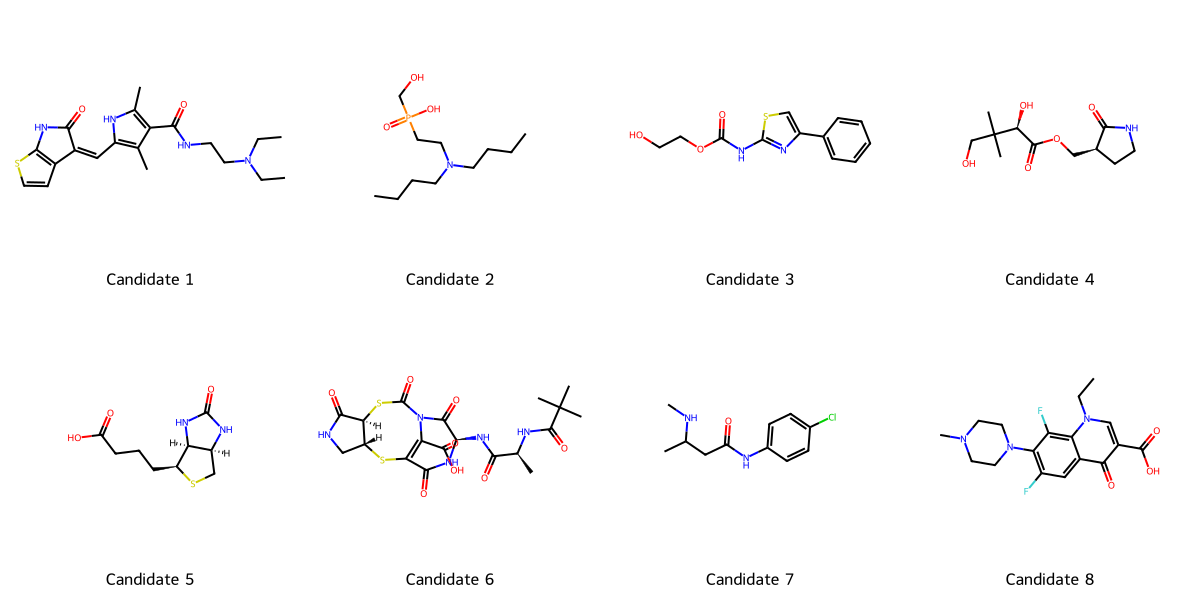

In [11]:
valid_molecules = []

print("\n--- Validation Results ---")
for smi in new_smiles:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        valid_molecules.append(mol)
        print(f"[VALID]   {smi}")
    else:
        print(f"[INVALID] {smi}")

print(f"\nSuccess Rate: {len(valid_molecules)}/{len(new_smiles)} molecules are chemically valid.")

# Visualize the valid ones
if valid_molecules:
    img = Draw.MolsToGridImage(valid_molecules[:8], molsPerRow=4, subImgSize=(300, 300), legends=[f"Candidate {i+1}" for i in range(len(valid_molecules))])
    display(img)

In [12]:
from rdkit.Chem import Descriptors

def check_lipinski(mol):
    # Calculate properties
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)

    # Check conditions
    conditions = [
        mw < 500,
        logp < 5,
        hbd < 5,
        hba < 10
    ]

    return {
        "MW": round(mw, 2),
        "LogP": round(logp, 2),
        "HBD": hbd,
        "HBA": hba,
        "Pass": all(conditions)
    }

# Analyze our valid candidates
print("--- Drug-Likeness (Lipinski) Analysis ---")
drug_like_mols = []

for i, mol in enumerate(valid_molecules):
    results = check_lipinski(mol)
    if results["Pass"]:
        drug_like_mols.append(mol)
        status = "PASSED"
    else:
        status = "FAILED"

    print(f"Candidate {i+1}: {status} | MW: {results['MW']}, LogP: {results['LogP']}")

print(f"\nWe found {len(drug_like_mols)} drug-like candidates for HIV-1 Protease!")

--- Drug-Likeness (Lipinski) Analysis ---
Candidate 1: PASSED | MW: 386.52, LogP: 3.26
Candidate 2: PASSED | MW: 251.31, LogP: 2.11
Candidate 3: PASSED | MW: 264.31, LogP: 2.35
Candidate 4: PASSED | MW: 245.27, LogP: -0.95
Candidate 5: PASSED | MW: 230.29, LogP: 0.41
Candidate 6: FAILED | MW: 513.55, LogP: -1.3
Candidate 7: PASSED | MW: 226.71, LogP: 2.28
Candidate 8: PASSED | MW: 351.35, LogP: 1.75
Candidate 9: FAILED | MW: 373.5, LogP: 5.36
Candidate 10: PASSED | MW: 263.3, LogP: 0.41

We found 8 drug-like candidates for HIV-1 Protease!


In [14]:
import os
from rdkit.Chem import SDWriter

# 1. Define the correct path to your Colab Notebooks folder
# 'My Drive' and 'Colab Notebooks' both have spaces, so we define them carefully
base_path = "/content/drive/MyDrive/Colab Notebooks"
project_folder = "HIV_Drug_Discovery"
full_path = os.path.join(base_path, project_folder)

# 2. Check if the project sub-folder exists, if not, create it
if not os.path.exists(full_path):
    os.makedirs(full_path)
    print(f"Created new project folder inside Colab Notebooks: {full_path}")
else:
    print(f"Project folder found at: {full_path}")

# 3. Define the file name
output_file = os.path.join(full_path, "top_candidates.sdf")

# 4. Save the molecules
try:
    writer = SDWriter(output_file)
    if writer is None:
        raise IOError("Could not open SDWriter. Check Drive permissions.")

    for i, mol in enumerate(drug_like_mols):
        mol.SetProp("_Name", f"HIV_Drug_{i+1}")
        writer.write(mol)

    writer.close()
    print(f"DONE! Your {len(drug_like_mols)} molecules are saved here: {output_file}")
except Exception as e:
    print(f"Failed to save: {e}")

Created new project folder inside Colab Notebooks: /content/drive/MyDrive/Colab Notebooks/HIV_Drug_Discovery
DONE! Your 8 molecules are saved here: /content/drive/MyDrive/Colab Notebooks/HIV_Drug_Discovery/top_candidates.sdf
